## testing several models for both the SeaFlow and Zinser (updated) datasets
 * modified from 2020-04-15 notebook with model using updated data fitting
 * this is to test size-dependence for growth/respiration

### load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for k in datafiles:
    data_gridded[k] = {}
    with nc4.Dataset(datafiles[k]) as nc:
        for var in nc.variables:
            data_gridded[k][var] = nc.variables[var][:]
    desc[k] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[k])

data_gridded[k]['PAR'] *= 200.0/22.0 # make light similar for this experiment (it is later normalized by E_star) 

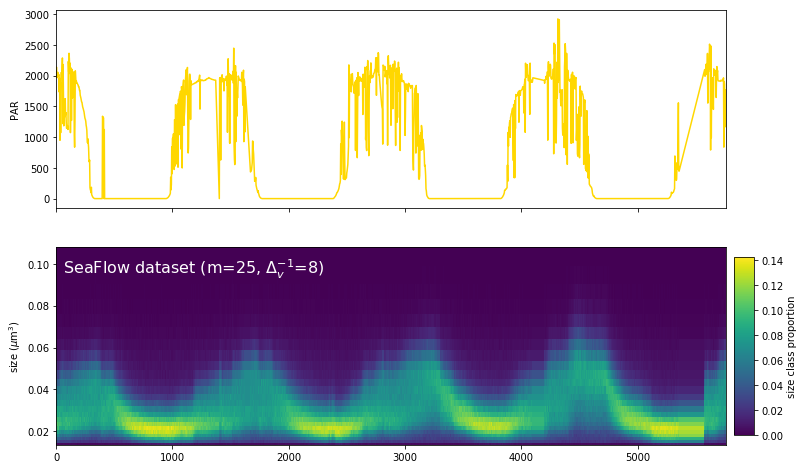

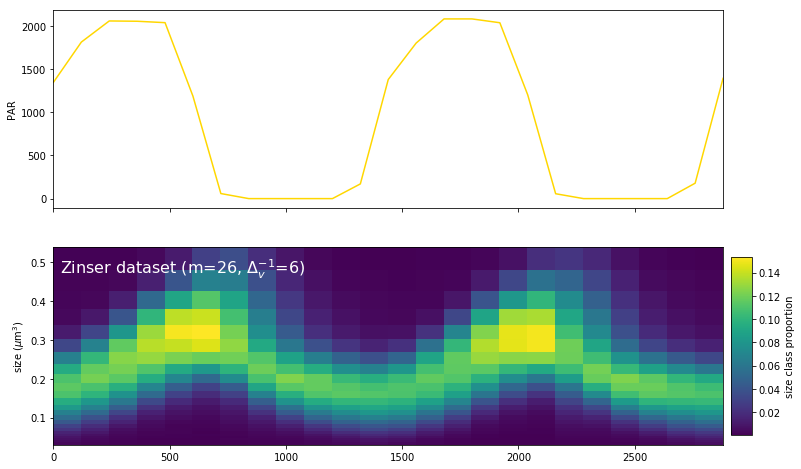

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,k in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.plot(data_gridded[k]['time'], data_gridded[k]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[k]['v_min']
    delta_v = 1.0/data_gridded[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[k]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[k]['time'],v,data_gridded[k]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[k], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

### process data and plot it

In [3]:
# prepare data for Stan model

data = {}
mcmcs = {}
models = {}

In [4]:
for k in data_gridded:
    dt = 20 # in units of minutes
    
    data[k] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[k][v] = data_gridded[k][v]

    if 'seaflow' in k:
        limit_days = 1
        
        # new: average SeaFlow data in hourly bins
        binsize = 60 # in minutes
        numbins = int(np.ceil(data_gridded[k]['time'][-1]/binsize))
        
        data[k]['obs'] = np.full((data[k]['m'],numbins), fill_value=np.nan)
        data[k]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
        i = 0
        for ibin in range(numbins):
            binind = np.logical_and(data_gridded[k]['time'] >= ibin*binsize,
                                    data_gridded[k]['time'] < (ibin+1)*binsize)
            if np.any(binind):
                # TODO we may want to make this a sum when dealing with counts
                data[k]['obs'][:,i] = np.mean(data_gridded[k]['w_obs'][:,binind], axis=1)
                data[k]['t_obs'][i] = (ibin+0.5) * binsize
                i += 1
        
        data[k]['obs'] = data[k]['obs'][:,:i]
        data[k]['t_obs'] = data[k]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[k]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[k]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[k]['obs'] = data_gridded[k]['w_obs']
        data[k]['t_obs'] = data_gridded[k]['time']
        par = data_gridded[k]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[k]['t_obs'] < limit_minutes
        data[k]['t_obs'] = data[k]['t_obs'][ind_obs]
        data[k]['obs'] = data[k]['obs'][:,ind_obs]
        
        data[k]['nt'] = int(limit_minutes//data[k]['dt'])

    data[k]['nt_obs'] = data[k]['t_obs'].size
    
    # load cross-validation testing indices and add them to data
    data[k]['i_test'] = np.loadtxt(itestfiles[k]).astype(int)
    # remove last index, so that dimensions agree
    data[k]['i_test'] = data[k]['i_test'][:-1]
    
    # add light data
    t = np.arange(data[k]['nt'])*data[k]['dt']
    data[k]['E'] = np.interp(t, xp=data_gridded[k]['time'], fp=par)
    
    # for now, add pseudo-count data
    data[k]['obs_count'] = (1000*data[k]['obs']).astype(int)
    
    # consistency check
    if len(data[k]['i_test']) != data[k]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(k,data[k]['nt_obs'],len(data[k]['i_test'])))

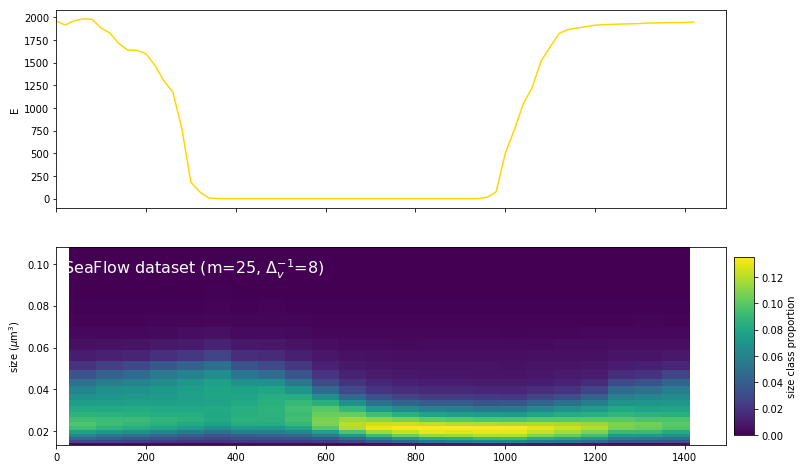

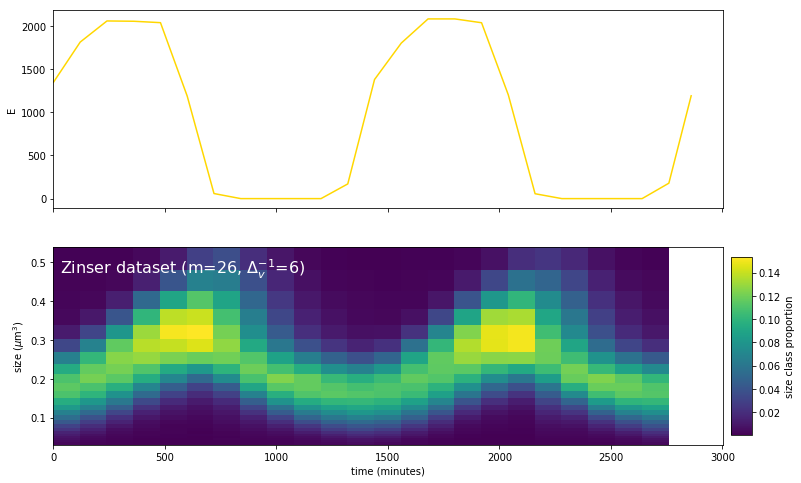

In [5]:
for i,k in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    t = np.arange(data[k]['nt'])*data[k]['dt']
    ax.plot(t, data[k]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[k]['v_min']
    delta_v = 1.0/data[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data[k]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[k]['t_obs'],v,data[k]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[k], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')

None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [20]:
import pystan
refit_all = False
refit_required = {}

modelfiles = {
    'monodelta_respv2_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    'monodelta_respi_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respi_gammai_normparam_trackgrowth_xval.stan',
    'monodelta_respiv2_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv2_normparam_trackgrowth_xval.stan',
    'monodelta_respiv3_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv3_normparam_trackgrowth_xval.stan',
    'monodelta_respiv4_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv4_normparam_trackgrowth_xval.stan',
}
desc_model = {
    'monodelta_respv2_mn':'model with resp v2, monotone deltas (exp AR1), multinomial',
    'monodelta_respi_mn':'model with size-dep respiration (old), monotone deltas (exp AR1), multinomial',
    'monodelta_respiv2_mn':'model with size-dep resp v2, monotone deltas (exp AR1), multinomial',
    'monodelta_respiv3_mn':'model with size-dep resp v3 (exp), monotone deltas (exp AR1), multinomial',
    'monodelta_respiv4_mn':'model with size-dep resp v4 (old & exp), monotone deltas (exp AR1), multinomial',
}

for name in modelfiles:
    with open(modelfiles[name]) as f: 
        stan_code = f.read()
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(file=modelfiles[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_respiv4_mn NOW.


monodelta_respv2_mn: unchanged code, not recompiling
monodelta_respi_mn: unchanged code, not recompiling
monodelta_respiv2_mn: unchanged code, not recompiling
monodelta_respiv3_mn: unchanged code, not recompiling
monodelta_respiv4_mn: compiling


In [30]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

try_again = True

# run a bunch of experiments -- this may take a while
for name in models:
    for k in data:
        if name in mcmcs:
            if k in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][k].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][k])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            mcmcs[name][k] = models[name].sampling(data=data[k], iter=2000)
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][k])
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][k].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))

monodelta_respv2_mn (model with respiration v2, monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respv2_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd     2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.32  4.1e-3     0.1     0.16    0.25    0.31    0.38    0.55    575   1.01
gamma_max             1.25  1.9e-3    0.05     1.15    1.22    1.25    1.29    1.36    736   1.01
respiration           0.03  6.5e-4    0.02   1.2e-3    0.01    0.02    0.04    0.07    704   1.01
E_star                12.7    1.25   30.82     0.09    0.83    1.76    6.47   83.31    608   1.01
divrate               0.74  1.2e-3    0.03     0.68    0.72    0.74    0.76    0.79    638   1.01
delta_max[1]          0.16  1.2e-3    0.03     0.09    0.13    0.16    0.18    0.22    713    1.0
delta_max[2]          1.18  3.3e-3    0.09     1.02    1.12  

monodelta_respiv2_mn (model with size-dep respiration v2, monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respiv2_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
delta_lambda         3.04    1.41   2.02    1.21    1.69    2.04   5.26   6.48      2   5.77
gamma_max           10.83    1.55   2.23    8.56     9.3    9.79  13.44   14.6      2   4.65
xi                  -0.54    0.22   0.32   -0.84   -0.74   -0.69  -0.23 6.4e-5      2   5.87
respiration          2.34     0.9   1.28    0.14    1.23     3.0   3.14   3.39      2    9.7
E_star             954.16   257.4 374.92  560.78  691.44  782.02 1519.8 1580.4      2    4.0
divrate              1.63    1.13   1.59    0.65    0.69    0.72   2.77   4.38      2  66.18
delta_max[1]          0.2    0.15   0.21    0.02    0.06    0.09   0.38   0.57      2

monodelta_respiv3_mn (model with size-dep respiration v3 (exp), monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respiv3_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.01    1.45   2.06     0.3    0.42   0.64   4.55   5.43      2  10.57
gamma_max            7.45    2.04   2.89    3.05    5.24   7.64   9.81  11.34      2  54.59
xi                  -0.35    0.44   0.63   -0.98   -0.69  -0.58   0.15   0.71      2   18.7
respiration          0.59     0.3   0.42    0.13    0.17   0.52   0.98   1.18      2  18.09
E_star             663.53  174.32 249.89  434.76  436.48 524.48 999.71 1076.2      2   6.03
divrate              3.45    1.13    1.6    0.66    2.35   4.27   4.45   4.59      2  94.61
delta_max[1]         0.86    0.72   1.01    0.04    0.19   0.38   1.64    2.6      2  

monodelta_respiv3_mn: in try 1/3 found Rhat=665.933, trying again


monodelta_respiv3_mn: in try 2/3 found Rhat=1665.647, trying again


monodelta_respiv3_mn: in try 3/3 found Rhat=1458.276, trying again
monodelta_respiv3_mn (model with size-dep respiration v3 (exp), monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respiv3_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.89    1.37   1.95    0.31    0.35    0.57   4.22    5.1      2  10.76
gamma_max           13.56    6.91   9.77    3.06     6.2   10.77  21.77  29.49      2 195.75
xi                  -0.32    0.29   0.41   -0.97   -0.53   -0.34   0.03   0.28      2  13.17
respiration          0.54    0.28    0.4    0.17    0.17    0.44   0.86   1.18      2  19.01
E_star             1785.4  1077.2 1524.3  503.73  508.87  1335.5 3134.6 4294.9      2  36.95
divrate              3.38     1.1   1.56    0.66    2.22     4.1   4.44    4.6      2   96.1
delta_max[1]

monodelta_respi_mn: found Rhat=976.430, trying again


monodelta_respi_mn: in try 1/3 found Rhat=144.357, trying again


monodelta_respi_mn: in try 2/3 found Rhat=2782.387, trying again


monodelta_respi_mn: in try 3/3 found Rhat=3593.013, trying again
monodelta_respi_mn (model with size-dep respiration (old), monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respi_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
delta_lambda          2.8    1.77   2.53    0.33    0.44    1.23   6.33   6.35      2   6.16
gamma_max           17.44    4.87   6.92    9.95   10.68   16.25   25.8  28.65      2  10.38
xi                  -0.28    0.22   0.32   -0.88   -0.45   -0.16  -0.02 3.1e-4      2  10.77
respiration          1.27    0.82   1.16    0.16    0.23    0.93   1.99   3.26      2   13.5
xir                  0.06    0.34   0.48   -0.52   -0.42   -0.03    0.6   0.65      2  23.51
E_star             1826.9   998.4 1416.8  555.12  679.99  1135.7 3635.9 4213.2      2   12.0
divrate              

monodelta_respiv4_mn (model with size-dep respiration v4 (old with exp), monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respiv4_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.31  3.4e-3    0.09    0.17    0.24     0.3    0.36    0.51    653   1.01
gamma_max             1.29  2.8e-3    0.06    1.18    1.25    1.29    1.33    1.41    438   1.01
xi                    0.03  3.2e-3     0.1   -0.16   -0.03    0.04     0.1    0.23   1013    1.0
respiration           0.11  9.8e-4    0.02    0.06     0.1    0.11    0.12    0.15    496    1.0
xir                 2.1e-3  2.8e-3     0.1   -0.19   -0.06  3.9e-3    0.07    0.19   1167    1.0
E_star               10.12    0.96   25.79    0.07    0.73    1.68    4.22   76.44    720   1.01
divrate               0.68  1.3e-3    0.03

monodelta_respiv4_mn: in try 1/3 found Rhat=584.369, trying again


monodelta_respiv4_mn: in try 2/3 found Rhat=944.485, trying again


monodelta_respiv4_mn: in try 3/3 found Rhat=5461.310, trying again
monodelta_respiv4_mn (model with size-dep respiration v4 (old with exp), monotone deltas (exp AR1), multinomial)
Inference for Stan model: monodelta_respiv4_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd    2.5%     25%    50%    75%   97.5%  n_eff   Rhat
delta_lambda         0.73    0.43   0.61     0.2    0.23    0.5   1.27    1.72      2 951.09
gamma_max           11.68    2.24   3.17    7.52    8.84  11.47  14.55   16.25      2 1685.0
xi                  -0.37    0.42    0.6   -0.75   -0.74   -0.7   0.06    0.66      2 5461.3
respiration          0.45    0.27   0.39     0.1    0.18    0.3   0.75    1.11      2 1265.5
xir                  0.13    0.26   0.37   -0.33   -0.18   0.07   0.45     0.7      2 904.82
E_star             1688.8   667.5 944.22  535.64  982.07 1523.4 2429.9  3167.8      2 1687.3
div

## Plot the results

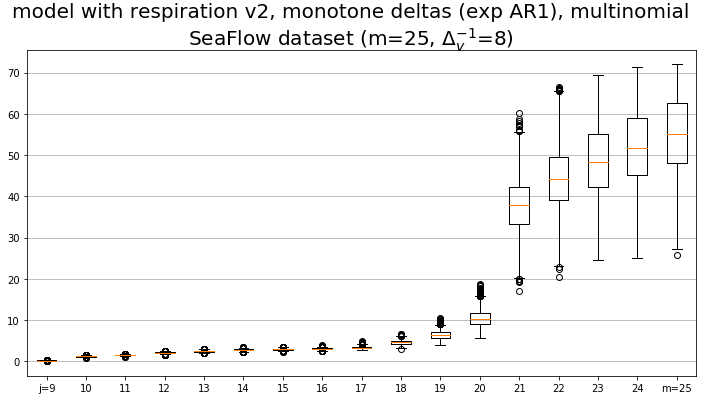

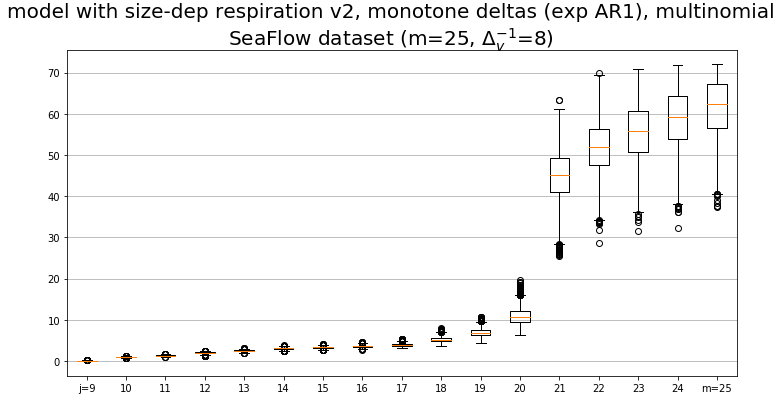

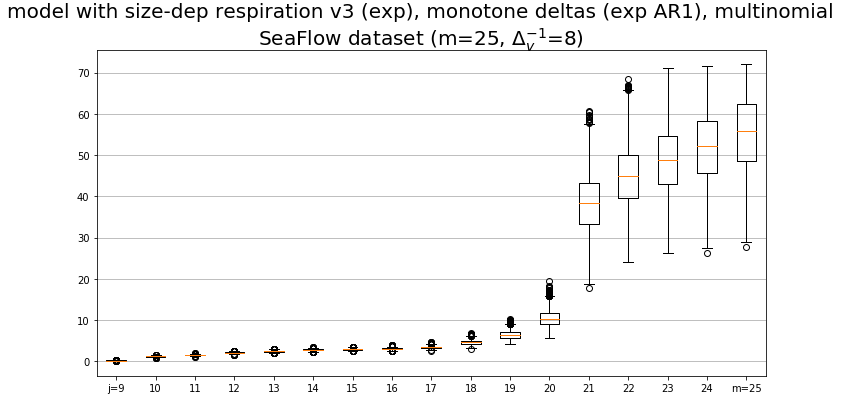

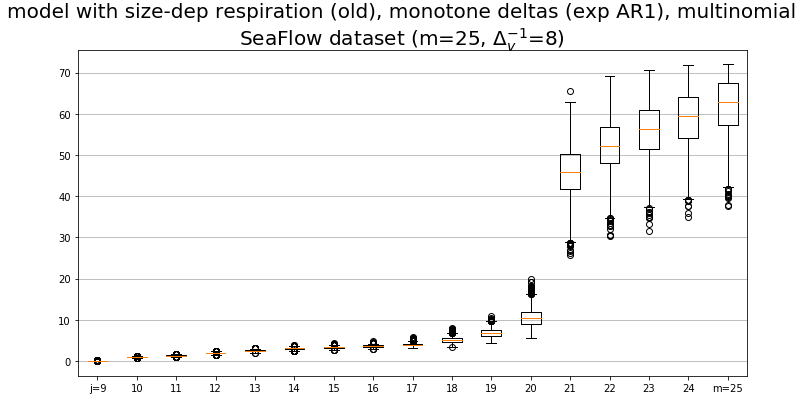

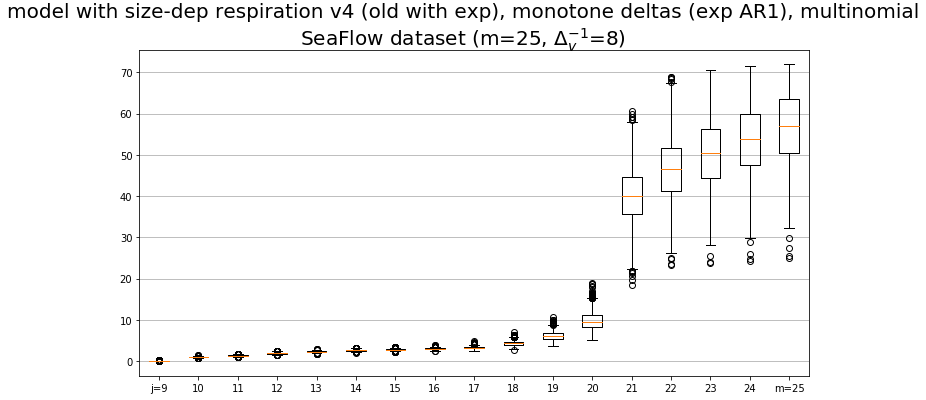

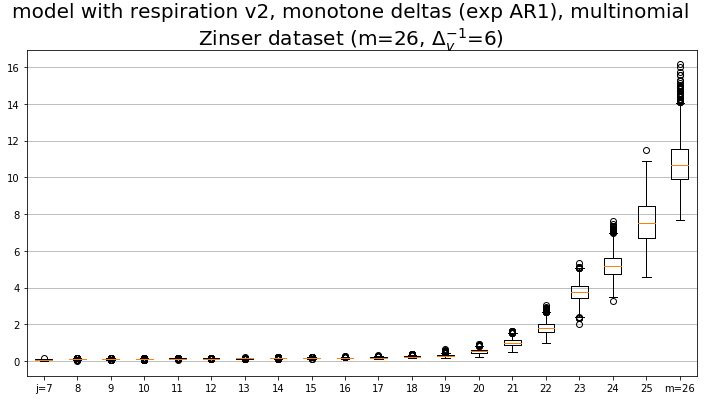

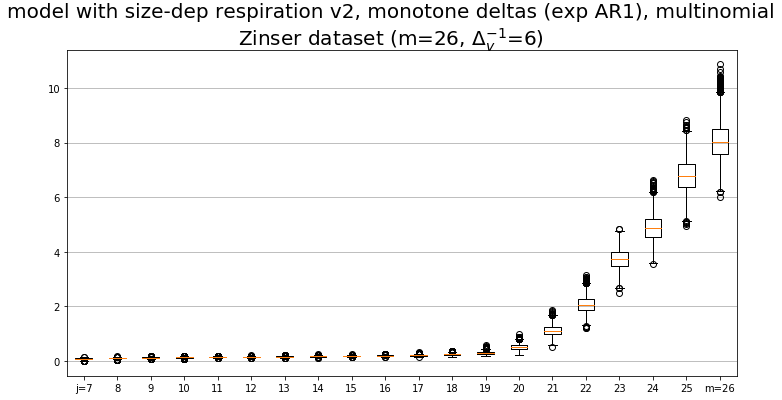

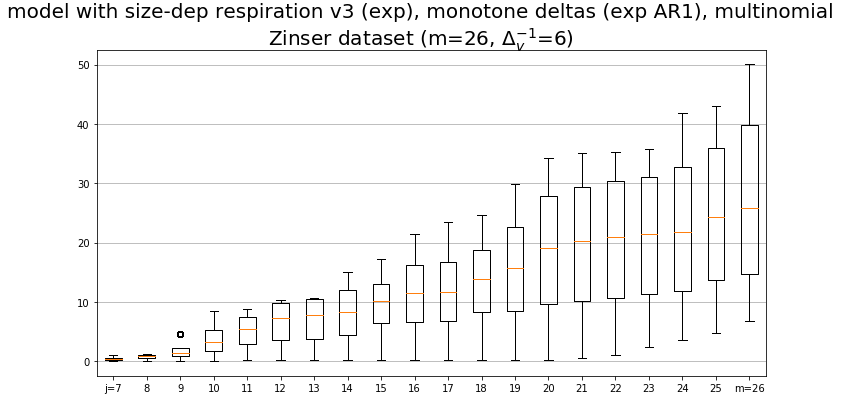

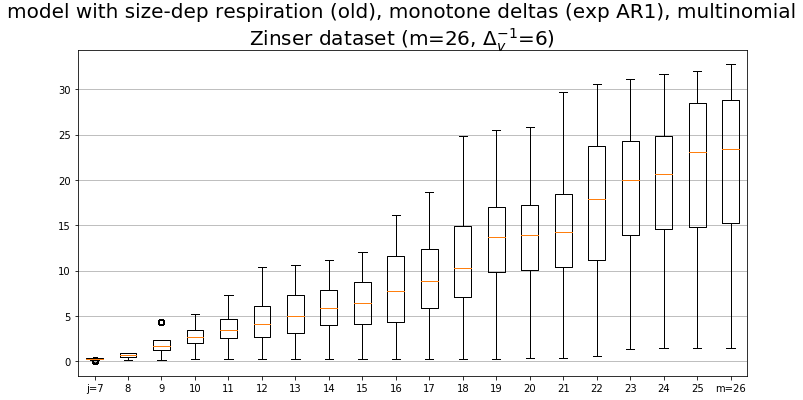

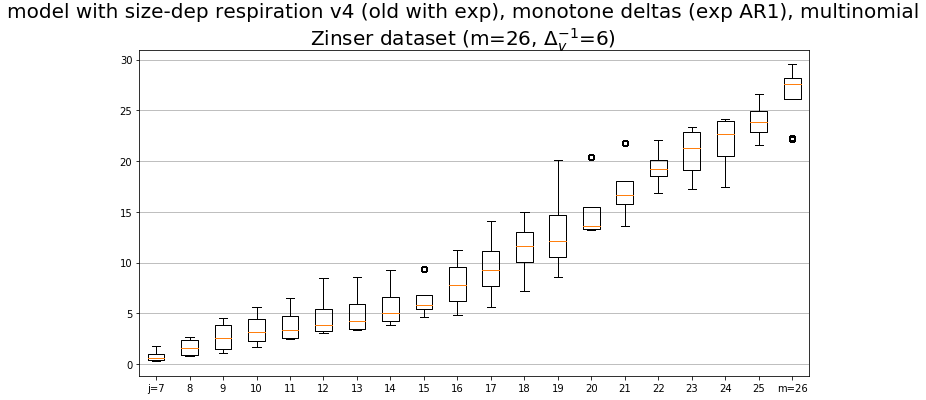

In [31]:
for k in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[k]['delta_v_inv'] + 1
        m = data_gridded[k]['m']

        fig, ax = plt.subplots(figsize=(12,6))
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)
        ax.boxplot(mcmc[k]['delta_max'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        None

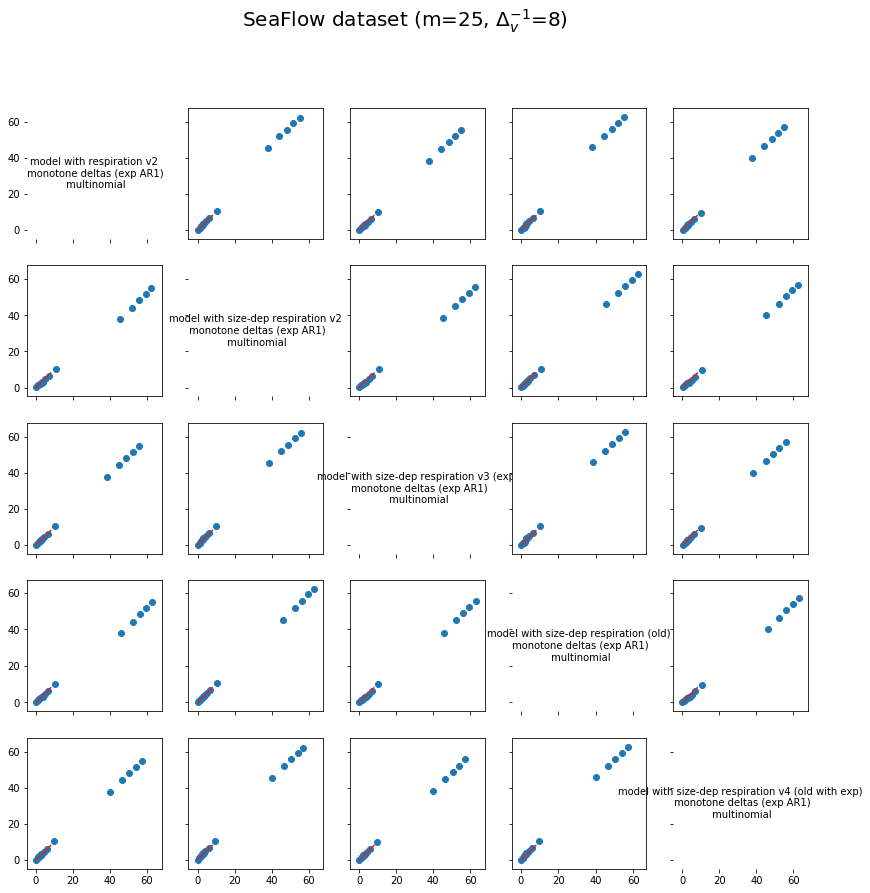

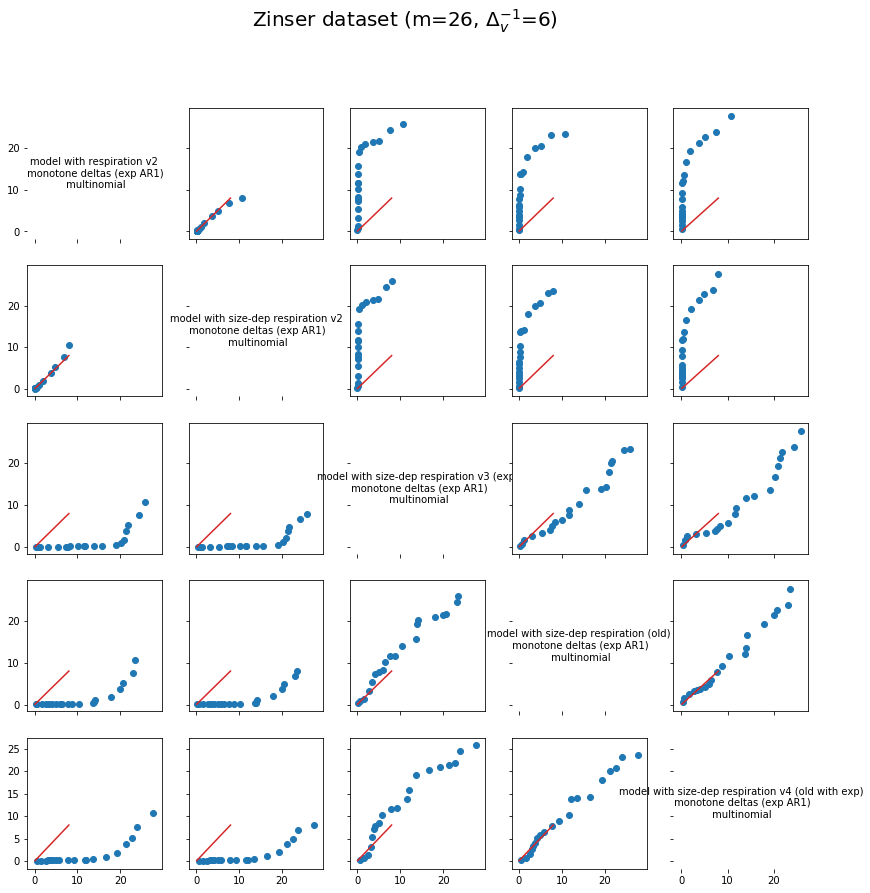

In [32]:
# create a 
for k in data:
    n = len(mcmcs)
    if n > 1:
        tmpdata = {}
        for name in mcmcs:
            tmpdata[name] = np.median(mcmcs[name][k]['delta_max'], axis=0)

        fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(14,14), sharex='col', sharey='row')
        fig.suptitle(desc[k], size=20)
        for irow,colname in enumerate(mcmcs):
            for icol,rowname in enumerate(mcmcs):
                ax = axs[irow,icol]
                if irow == icol:
                    for loc in ax.spines:
                        ax.spines[loc].set_visible(False)
                    #ax.set_visible(False)
                    #ax.set(xticks=[], yticks=[])
                    ax.text(0.5, 0.5, desc_model[colname].replace(',','\n'), transform=ax.transAxes, va='center', ha='center')
                    continue
                ax.scatter(tmpdata[colname],tmpdata[rowname])
                ax.plot([0.1, 8.0], [0.1, 8.0], color='tab:red')

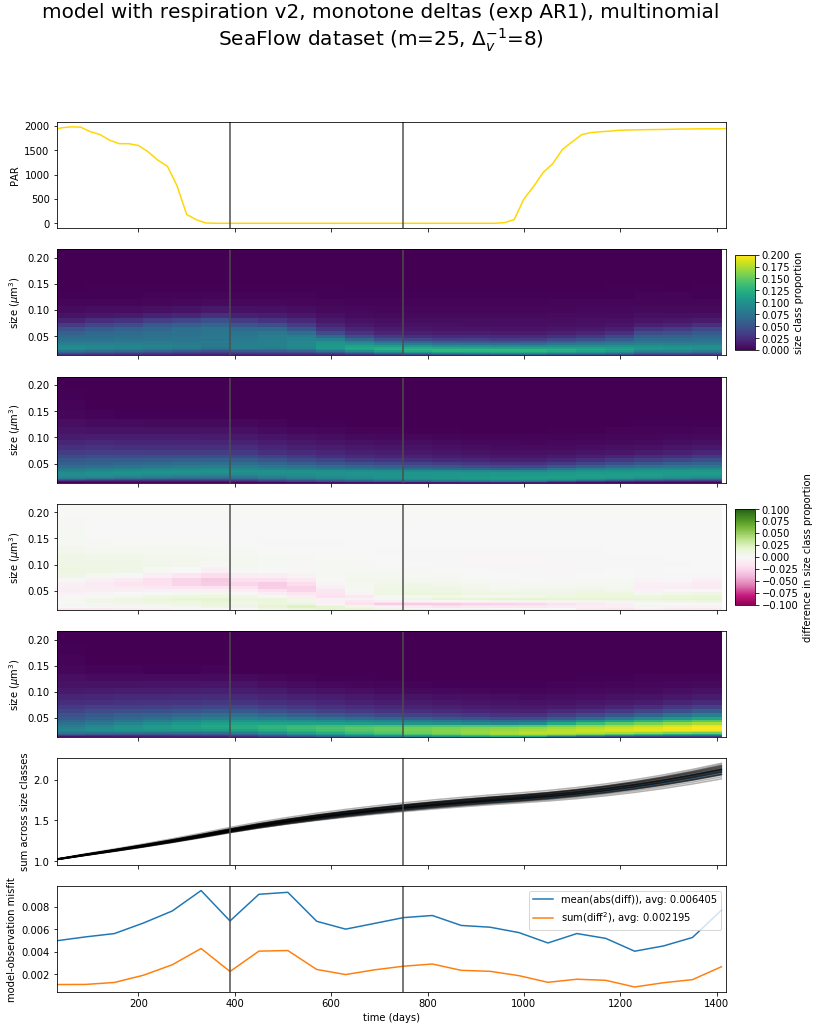

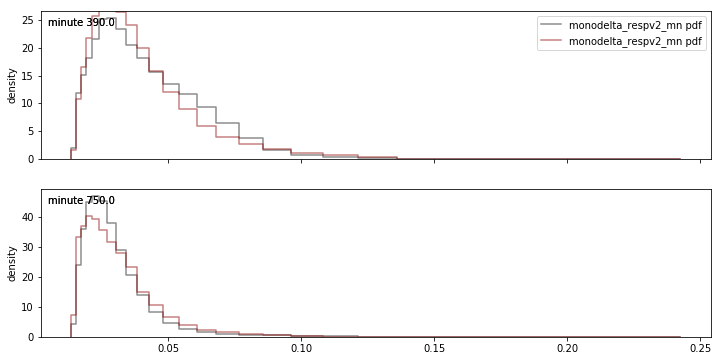

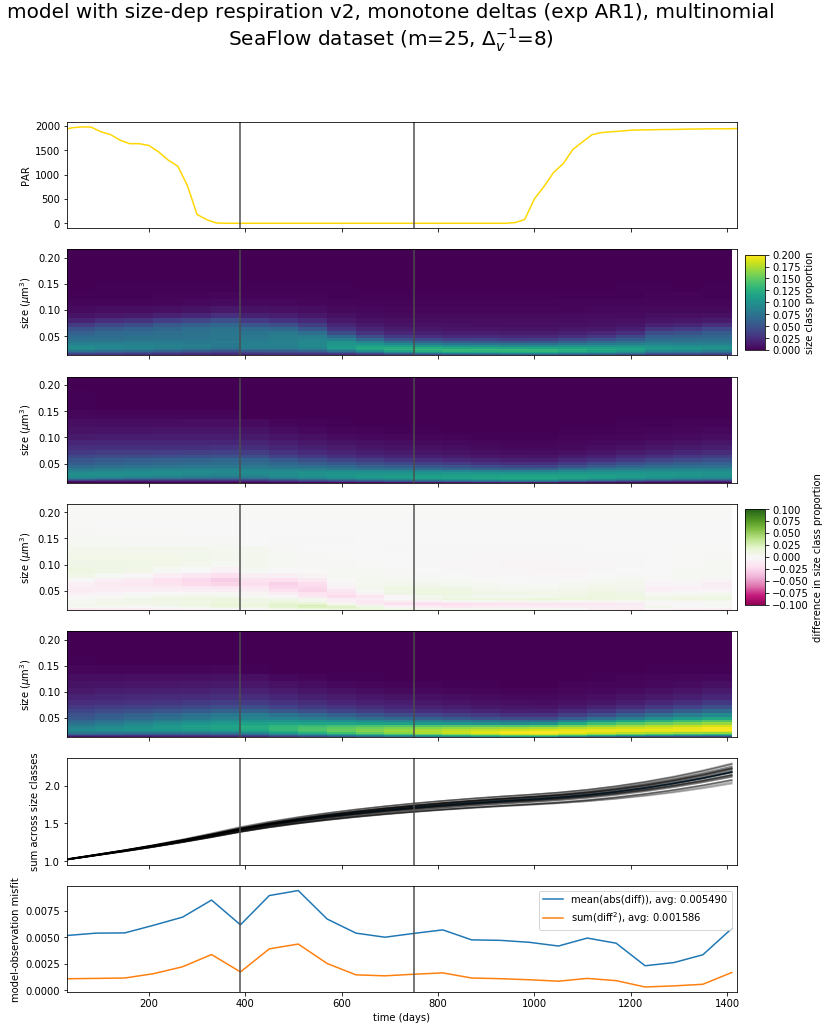

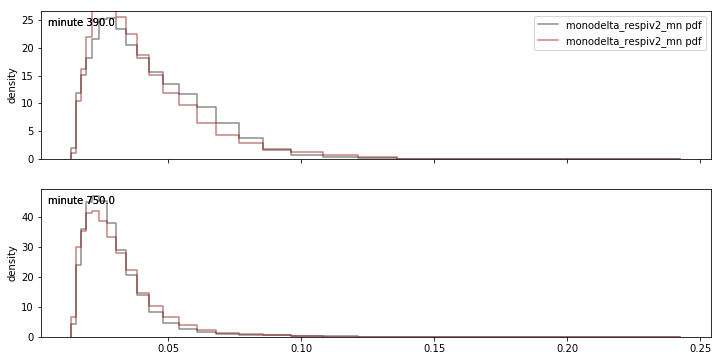

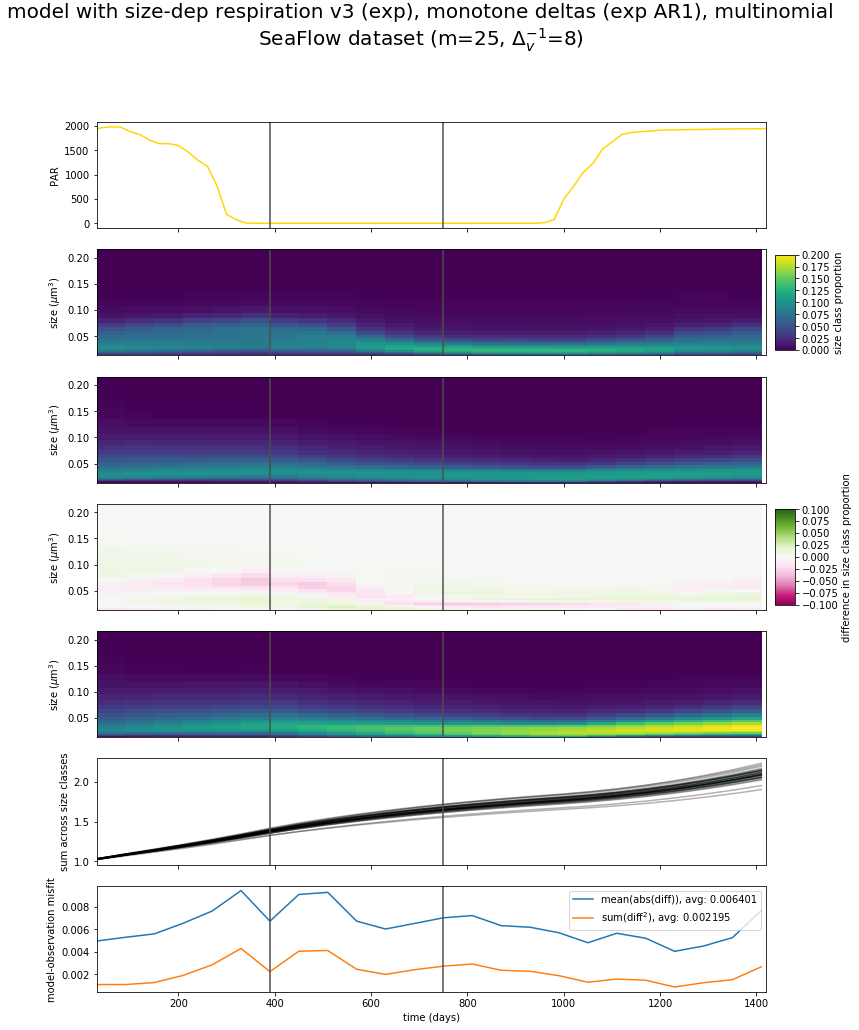

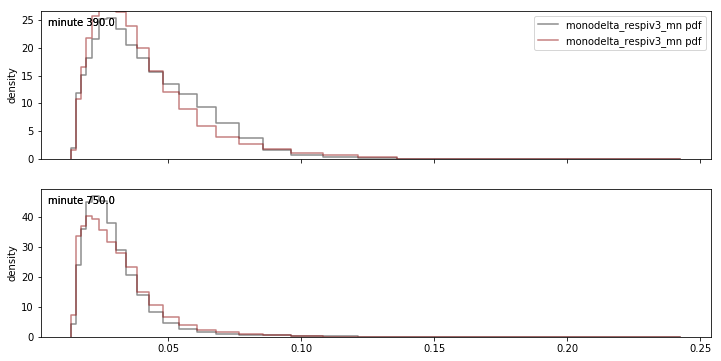

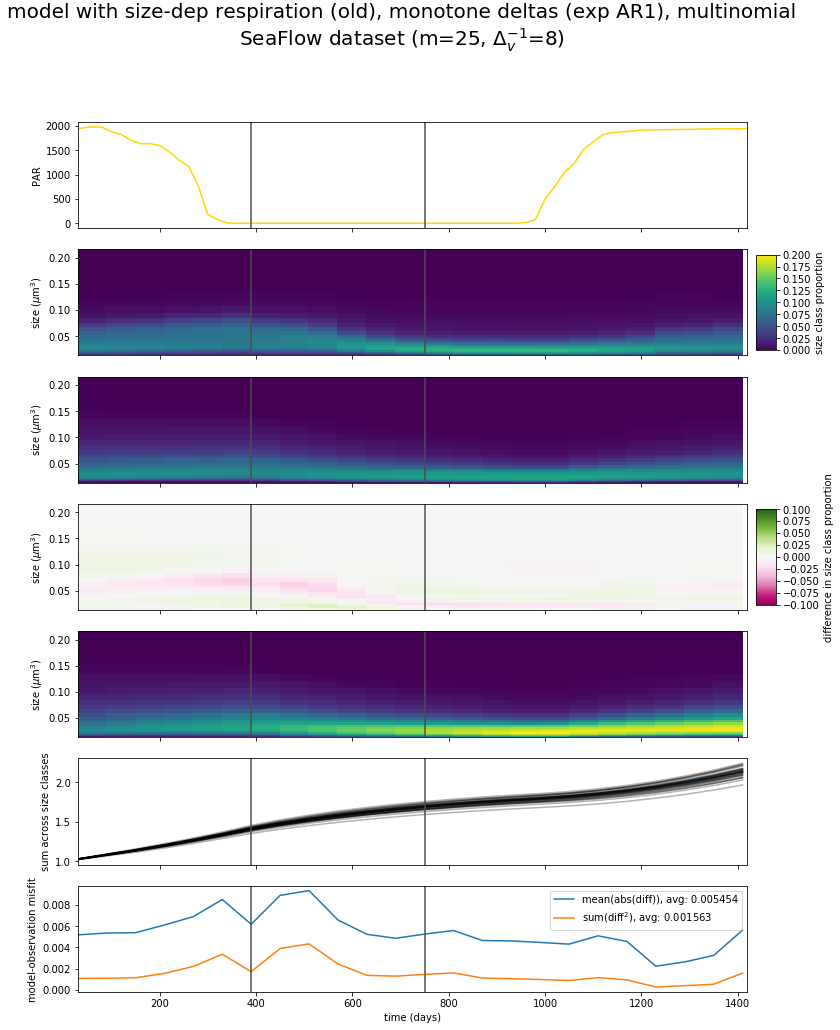

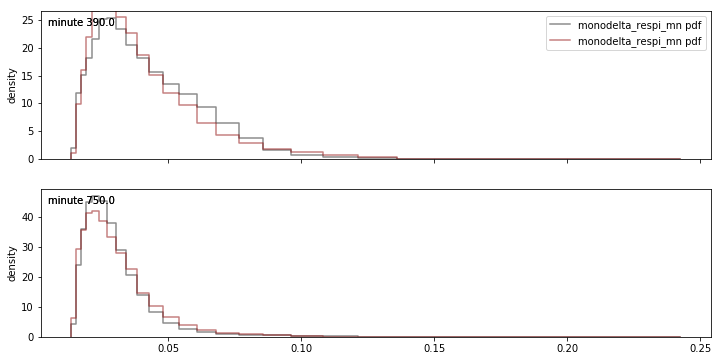

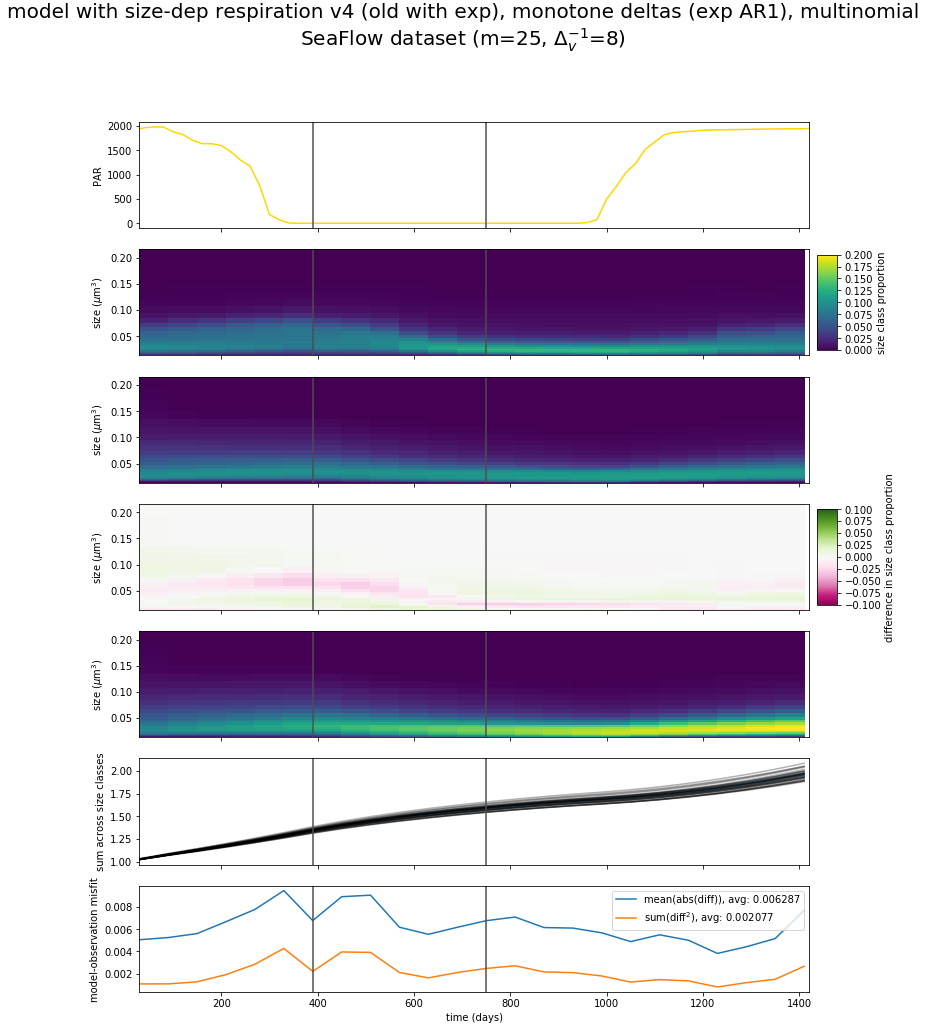

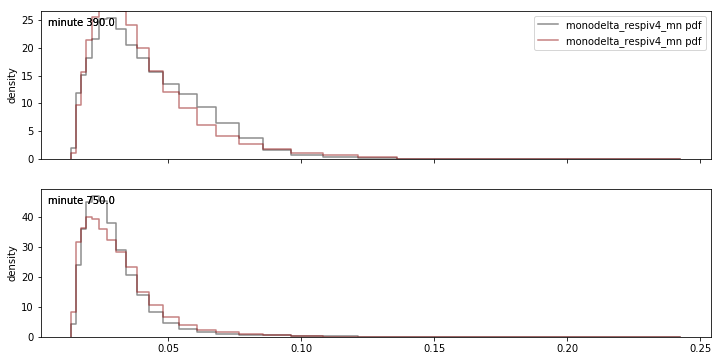

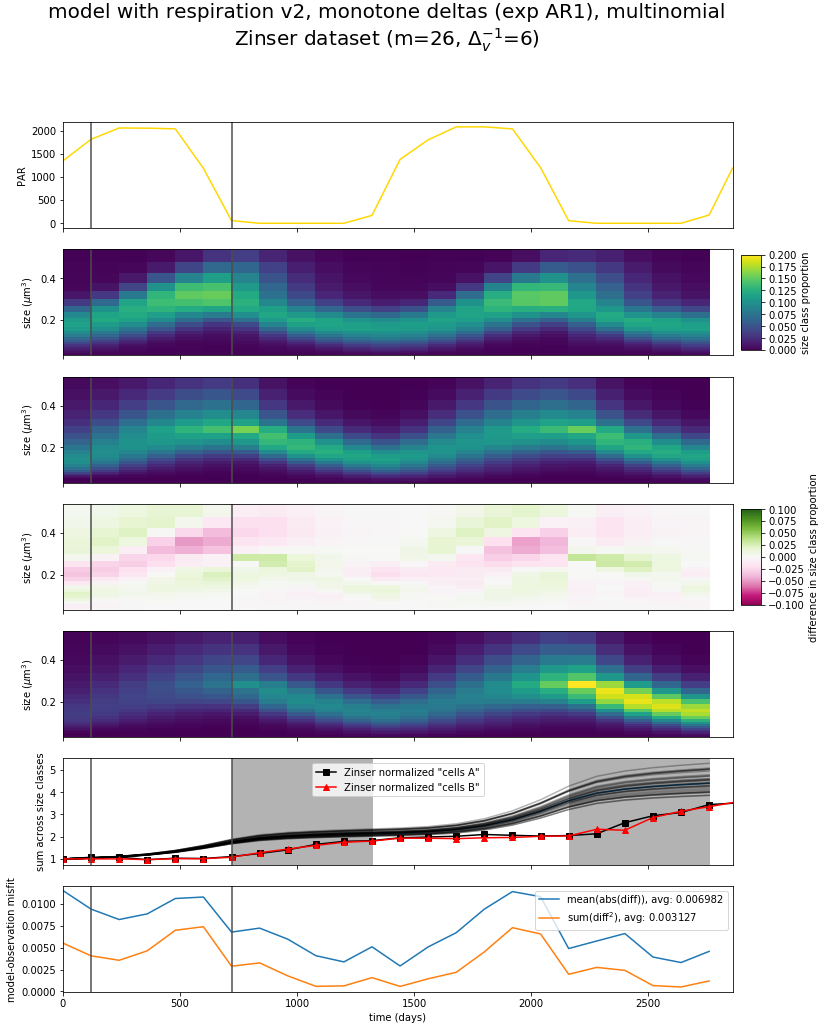

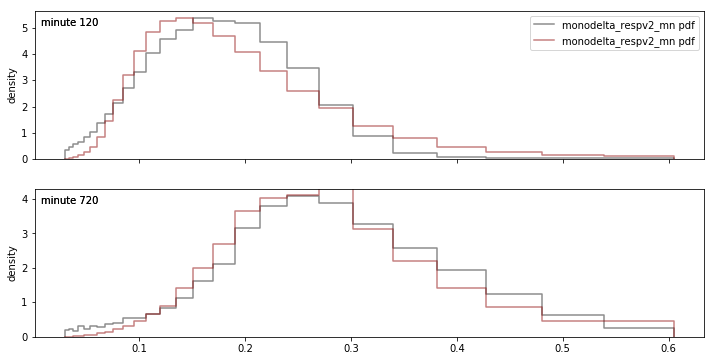

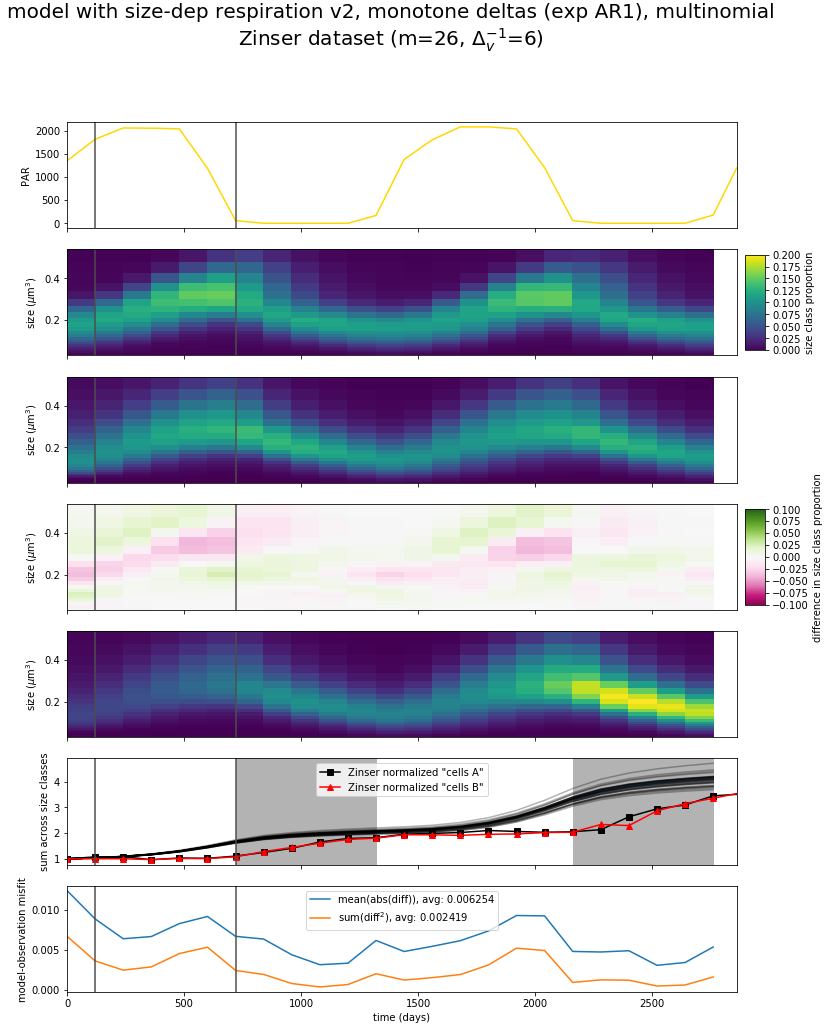

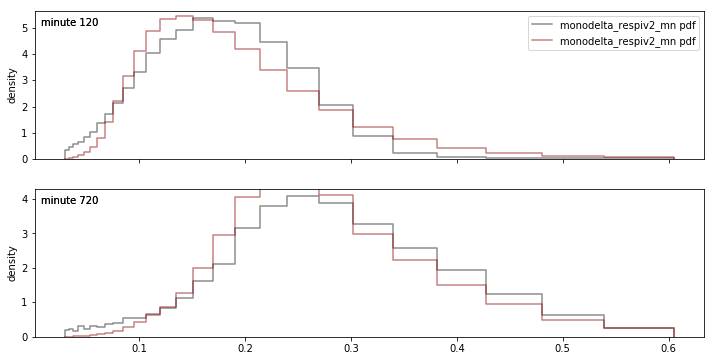

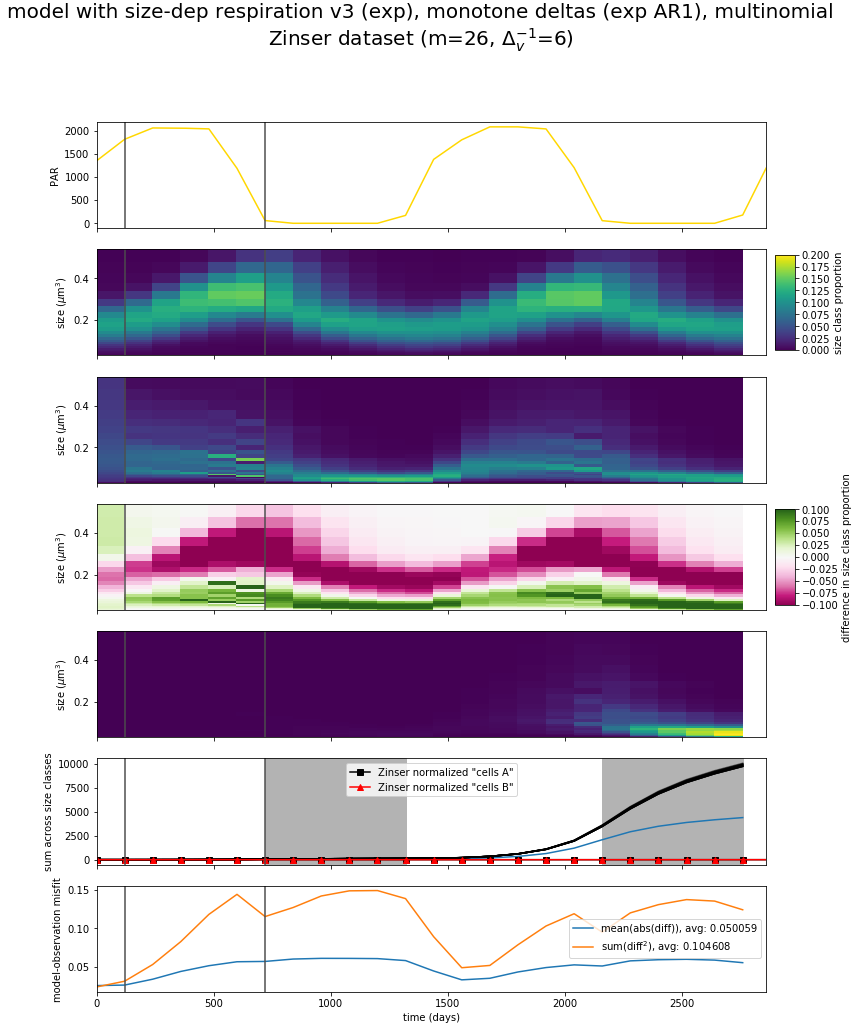

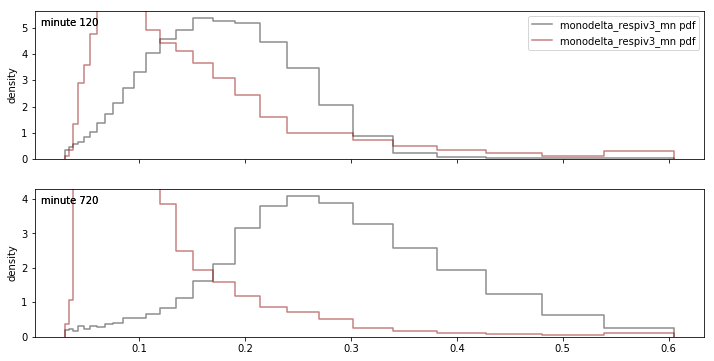

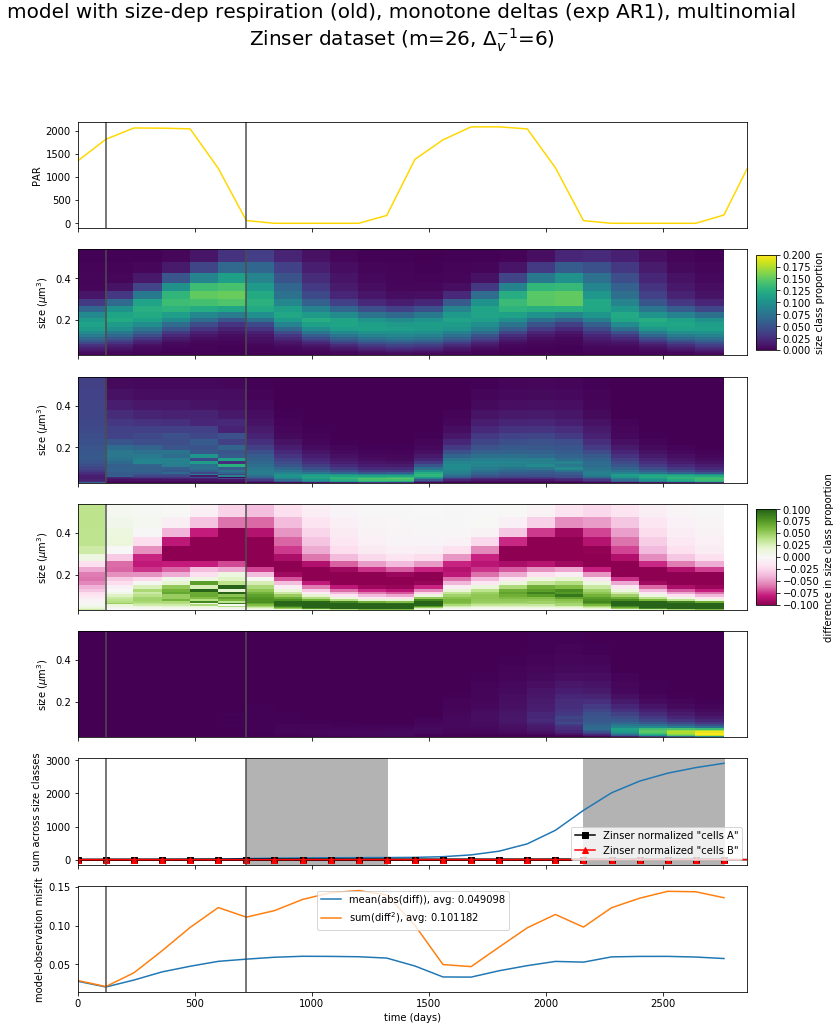

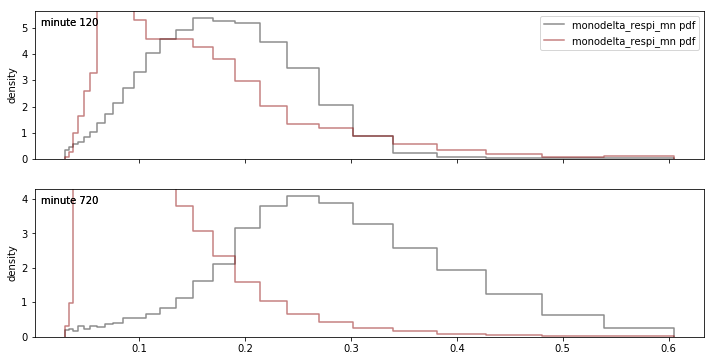

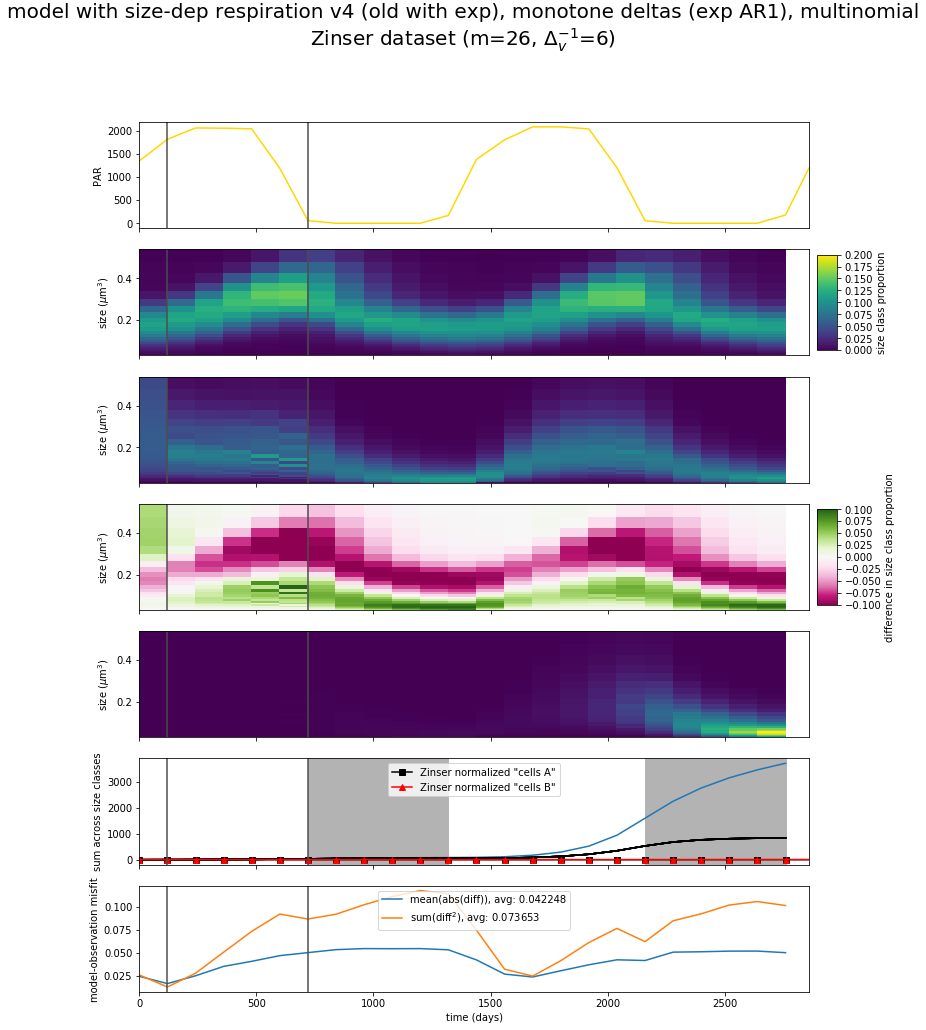

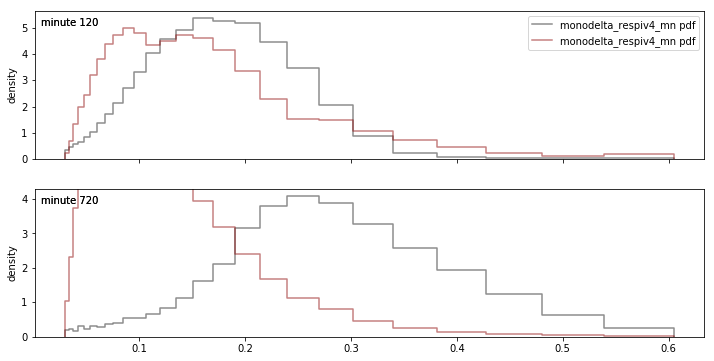

In [33]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for k in data:
    for name,mcmc in mcmcs.items():
        t = data[k]['dt']*np.arange(data[k]['nt'])
        if 'zinser' in k:
            slice_indices = [1,6]
        else:
            slice_indices = [6,12]
        v_ext = data[k]['v_min'] * 2**(np.arange(data[k]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[k]['mod_obspos'], axis=0), 'obs':data[k]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        fig,axs = plt.subplots(7,1,sharex=True,figsize=(12,16))
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)

        ax = axs[0]
        ax.plot(t, data[k]['E'], color='gold')
        ax.set(xlim=(data[k]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[k]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)')
        pc = ax.pcolormesh(data[k]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[k]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

        ax = axs[4]
        ax.set(ylabel='size ($\mu$m$^3$)')
        pc = ax.pcolormesh(data[k]['t_obs'],v,res['model'])

        ax = axs[5]
        ax.plot(data[k]['t_obs'], np.sum(res['model'],axis=0))
        ax.plot(data[k]['t_obs'], np.sum(mcmc[k]['mod_obspos'][:30,...], axis=1).T, color='k', alpha=0.3)
        if 'zinser' in k:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.set(ylabel='sum across size classes')

        ax = axs[6]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[k]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[k]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (days)', ylabel='model-observation misfit')
        ax.legend()

        for ax in axs.flat:
            for i in slice_indices:
                ax.axvline(data[k]['t_obs'][i], color='.3')

        # plot slices

        plotdata_y = np.zeros(2*(data[k]['m']+1))

        fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
        for i,ax in zip(slice_indices,axs.flat):
            for key in ('obs','model'):
                color = colors[key]
                cdata = res[key][:,i]
                cdata /= sum(cdata)
                plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
                ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
                ax.text(0.01, 0.95, 'minute {}'.format(data[k]['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
                ax.set_ylabel('density')
                ax.set_ylim(bottom=0.0)
        axs[0].legend()
        None

In [34]:
'''
for k in data:
    for name,mcmc in mcmcs.items():
        paramnames = [v for v in mcmc[k].flatnames if not v.startswith('mod_obspos') 
                      and not v.startswith('delta_max') and not v.startswith('w_ini') and not v.startswith('theta')]
        if len(paramnames) > 12:
            print('removing some parameters from plot')
            paramnames = paramnames[:12]
        num_params = len(paramnames)

        fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)
        for ax in axs.flat:
            ax.set_visible(False)
        for irow in range(1,num_params):
            for icol in range(irow):
                ax = axs[irow-1,icol]
                ax.set_visible(True)
                xname = paramnames[icol]
                yname = paramnames[irow]
                ax.hist2d(mcmc[k][xname],mcmc[k][yname],bins=50,cmap=mpl.cm.gray_r)
                if icol == 0:
                    ax.set_ylabel(yname)
                if irow == num_params-1:
                    ax.set_xlabel(xname)
'''
None

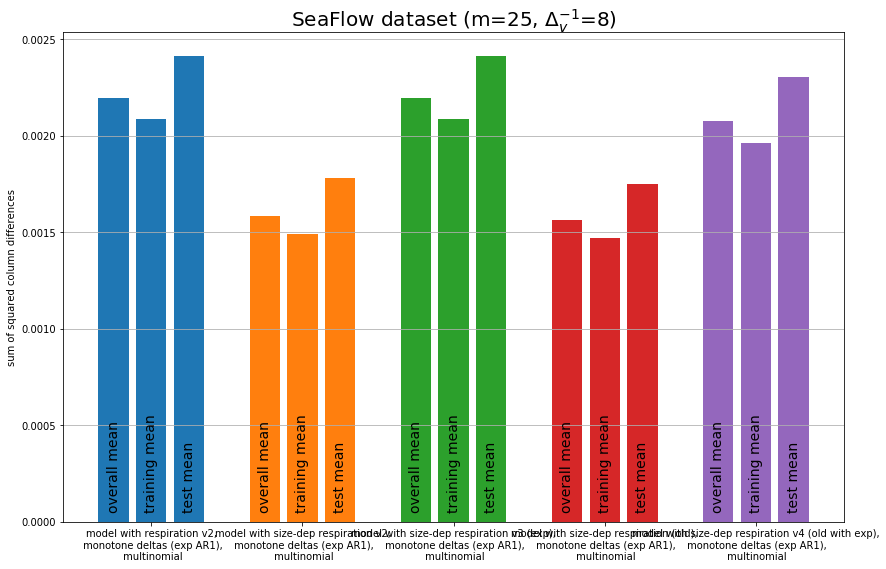

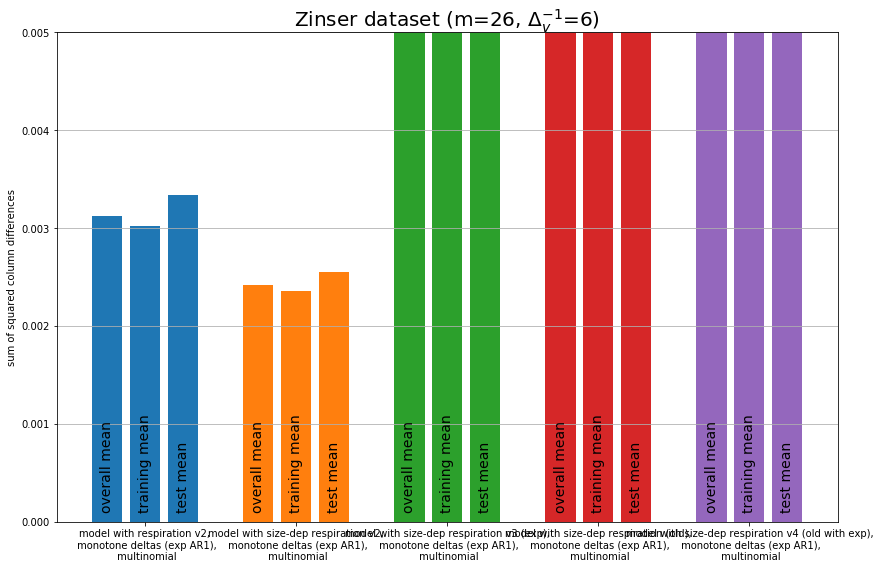

In [35]:
height = np.zeros(3)
for k in data:
    obs = data[k]['obs']
    
    fig, ax = plt.subplots(figsize=(14,9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][k]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        height[1] = np.mean(e[data[k]['i_test'] == 0])
        height[2] = np.mean(e[data[k]['i_test'] == 1])
        
        x = 4*i+np.arange(3)
        ax.bar(x=x, height=height)
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=14)
        xticks.append(x[1])
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title(desc[k], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')